In [127]:
import torch
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=4,  # the target image resolution
    in_channels=64,  # the number of input channels, 3 for RGB images
    out_channels=64,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
    ),
).cuda()

In [133]:
sample_image = torch.randn((1, 64, 4, 4)).cuda()

x = model(sample_image, timestep=0).sample

In [134]:
x.shape

torch.Size([1, 64, 4, 4])

In [138]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape).cuda()
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

In [ ]:
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).detach().cpu().numpy()[0])

In [146]:
import torch.nn.functional as F

noise_pred = model(noisy_image.cuda(), timesteps.cuda()).sample
loss = F.mse_loss(noise_pred, noise)

In [139]:
noisy_image.shape

torch.Size([1, 64, 4, 4])

In [147]:
loss

tensor(1.0544, device='cuda:0', grad_fn=<MseLossBackward0>)

In [131]:
x.shape

torch.Size([1, 64, 4, 4])

In [71]:
from diffusers import AutoencoderKL

In [103]:
vae = AutoencoderKL(
    in_channels=2,  # the number of input channels, 3 for RGB images
    out_channels=2,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 128, 128),  # the number of output channels for each UNet block
    latent_channels=8,
    down_block_types=(
        "DownEncoderBlock2D",  # a regular ResNet downsampling block
        "DownEncoderBlock2D",
        "DownEncoderBlock2D",
        "DownEncoderBlock2D",
    ),
    up_block_types=(
        "UpDecoderBlock2D",  # a regular ResNet upsampling block
        "UpDecoderBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpDecoderBlock2D",
        "UpDecoderBlock2D",
    ),    
).cuda()

In [104]:
z = vae.encode(torch.randn((1, 2, 100, 100)).cuda())

In [105]:
z.latent_dist.mean.shape

torch.Size([1, 8, 12, 12])

In [75]:
z.sample.shape

torch.Size([1, 3, 64, 64])

In [54]:
100 * 100 * 2

20000

In [56]:
4 * 16 * 16

1024

In [44]:
64 * 4 * 4

1024

In [1]:
from diffusers import AutoencoderKL

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [48]:
4*("DownEncoderBlock2D",)

('DownEncoderBlock2D',
 'DownEncoderBlock2D',
 'DownEncoderBlock2D',
 'DownEncoderBlock2D')

In [62]:
model = VQModel(in_channels=2, out_channels=2, down_block_types=2*("DownEncoderBlock2D",),
                up_block_types=2*("UpDecoderBlock2D",), block_out_channels=2*(64,))
# model = AutoencoderKL(in_channels=2, out_channels=2)
model.cuda()

VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, 

In [52]:
import torch

input_image = torch.randn((10, 2, 100, 100)).cuda()

In [63]:
output_image = model(input_image)

In [64]:
output_image.sample.shape

torch.Size([10, 2, 100, 100])

In [ ]:
model.encode

In [65]:
a = model.encode(input_image)

In [66]:
a.latents.shape

torch.Size([10, 3, 50, 50])

In [61]:
100 / 2 / 2

25.0

In [2]:
from diffusers import StableDiffusionPipeline

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [9]:
import torch
from imagen_pytorch import Unet, Imagen

# unet for imagen

unet1 = Unet(
    dim = 128,
    cond_dim = 512,
    dim_mults = (1, 2),
    num_resnet_blocks = 3,
    layer_attns = (False, True),
    layer_cross_attns = (False, True),
    cond_images_channels = 1,
    channels=1,
)


# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    unets = (unet1,),
    image_sizes = (4,),
    timesteps = 20,
    cond_drop_prob = 0.1,
    channels=64,
    text_embed_dim=768,
).cuda()

# mock images (get a lot of this) and text encodings from large T5

text_embeds = torch.randn(2, 1, 768).cuda()
images = torch.randn(2, 64, 4, 4).cuda()
cond_images = torch.randn(2, 1, 100, 100).cuda()

# feed images into imagen, training each unet in the cascade
loss = imagen(images, text_embeds = text_embeds, cond_images = cond_images, unet_number = 1)
loss.backward()

# do the above for many many many many steps
# now you can sample an image based on the text embeddings from the cascading ddpm

images = imagen.sample(text_embeds=text_embeds, cond_images = cond_images, cond_scale = 3.)

images.shape # (3, 3, 256, 256)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([2, 64, 4, 4])

In [2]:
import matplotlib.pyplot as plt

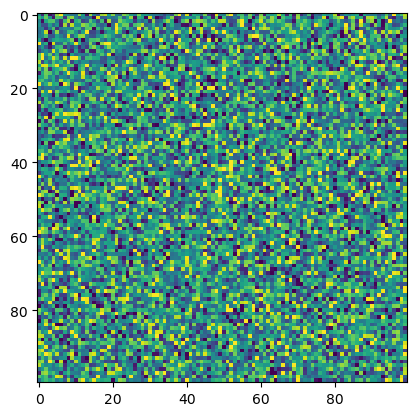

In [3]:
plt.imshow(images[1, 0].detach().cpu().numpy())